In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from __future__ import division

# Allow image embeding in notebook
%matplotlib inline


In [2]:
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels


# Load training and testing datasets.
ROOT_PATH = "/home/iamchristopher/Documents/Python/BelgianSign/traffic/traffic"
train_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Training")
test_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Testing")

images, labels = load_data(train_data_dir)


In [3]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))


Unique Labels: 62
Total Images: 4575


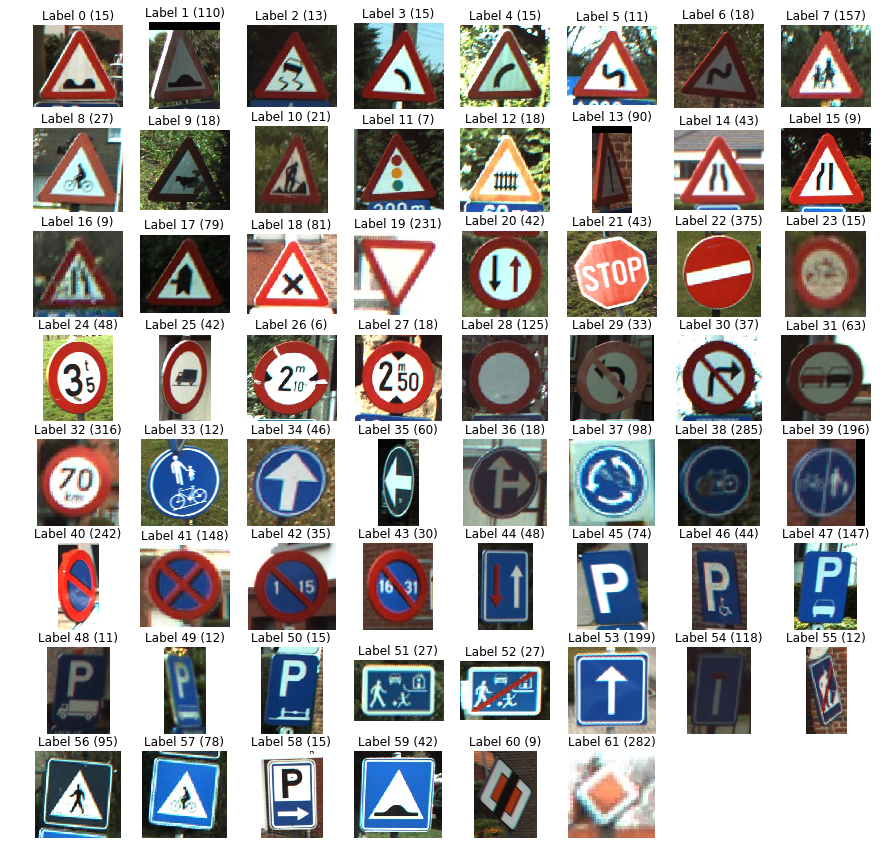

In [4]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

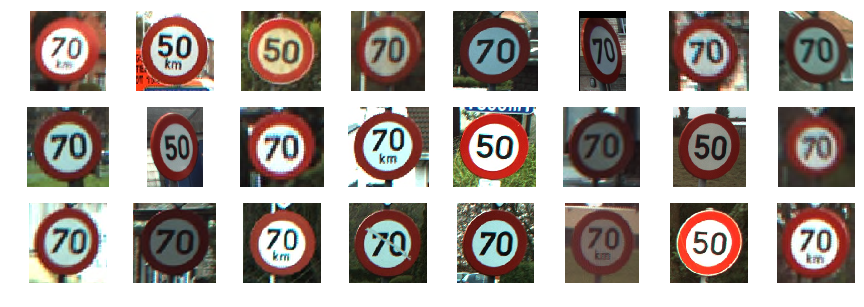

In [5]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 32)

In [6]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (118, 87, 3), min: 20, max: 115
shape: (155, 104, 3), min: 2, max: 255
shape: (298, 180, 3), min: 0, max: 255
shape: (93, 64, 3), min: 0, max: 251
shape: (190, 117, 3), min: 0, max: 255


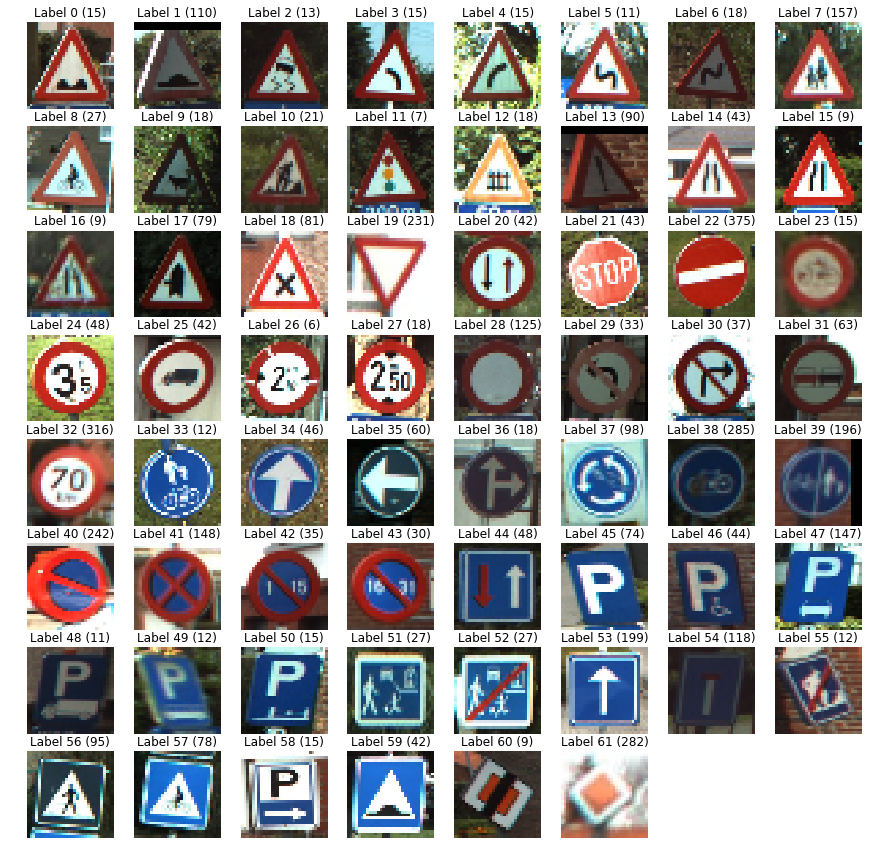

In [7]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32))
                for image in images]
display_images_and_labels(images32, labels)

In [8]:
#Clipping
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.0835171568627, max: 0.444362745098
shape: (32, 32, 3), min: 0.0549555759804, max: 1.0
shape: (32, 32, 3), min: 0.0124693627451, max: 1.0
shape: (32, 32, 3), min: 0.0261029411765, max: 0.962469362745
shape: (32, 32, 3), min: 0.0232977175245, max: 0.989052925858


In [9]:
# Prepare labels and images
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)




('labels: ', (4575,), '\nimages: ', (4575, 32, 32, 3))


In [16]:
# Create a graph to hold the model.
graph = tf.Graph()

training_epochs = 2500
display_step = 100
learning_rate = 0.05

# Create model in the graph.
with graph.as_default():
    #init = tf.initialize_all_variables()
    #tf.initialize_all_variables().run()
    # Placeholders for inputs and labels.
    images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.contrib.layers.flatten(images_ph)

    # Fully connected layer. 
    # Generates logits of size [None, 62]
    logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function. 
    # Cross-entropy is a good choice for classification.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels_ph))

    # Create training op.
    #train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    train = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    # And, finally, an initialization op to execute before training.
    # TODO: rename to tf.global_variables_initializer() on TF 0.12.
    init = tf.global_variables_initializer()

    print("images_flat: ", images_flat)
    print("logits: ", logits)
    print("loss: ", loss)
    print("predicted_labels: ", predicted_labels)
    
    
session = tf.Session(graph=graph)
_ = session.run([init])

for i in range(training_epochs):
    _, loss_value = session.run([train, loss], feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % display_step == 0:
        print("Loss: ", loss_value)

# Fit all training data
#for epoch in range(training_epochs):
#    for (x, y) in zip(images_flat, predicted_labels):
#        sess.run(train, feed_dict={X: x, Y: y})
            
# Display logs per epoch step
#    if (epoch+1) % display_step == 0:
#        c = sess.run(loss, feed_dict={X: images_flat, Y:predicted_labels})
#        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))

print("Optimization Finished!")

('images_flat: ', <tf.Tensor 'Flatten/Reshape:0' shape=(?, 3072) dtype=float32>)
('logits: ', <tf.Tensor 'fully_connected/Relu:0' shape=(?, 62) dtype=float32>)
('loss: ', <tf.Tensor 'Mean:0' shape=() dtype=float32>)
('predicted_labels: ', <tf.Tensor 'ArgMax:0' shape=(?,) dtype=int64>)
('Loss: ', 4.2931743)
('Loss: ', 2.264343)
('Loss: ', 1.9296004)
('Loss: ', 1.7811323)
('Loss: ', 1.6835505)
('Loss: ', 1.6137956)
('Loss: ', 1.5609149)
('Loss: ', 1.519249)
('Loss: ', 1.4853766)
('Loss: ', 1.4569534)
('Loss: ', 1.4325508)
('Loss: ', 1.4107289)
('Loss: ', 1.3915095)
('Loss: ', 1.3743654)
('Loss: ', 1.3589922)
('Loss: ', 1.3451419)
('Loss: ', 1.3325413)
('Loss: ', 1.3210057)
('Loss: ', 1.3104678)
('Loss: ', 1.3007998)
('Loss: ', 1.2918934)
('Loss: ', 1.2836597)
('Loss: ', 1.2760208)
('Loss: ', 1.2689083)
('Loss: ', 1.2622675)
Optimization Finished!


In [11]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

[53, 22, 13, 32, 37, 17, 29, 28, 20, 46]
[53 22 56 32 37 17 40 28 20 45]


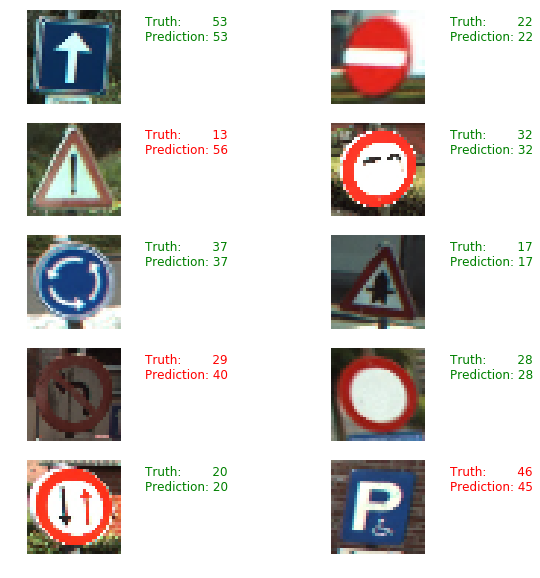

In [12]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])

In [13]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)

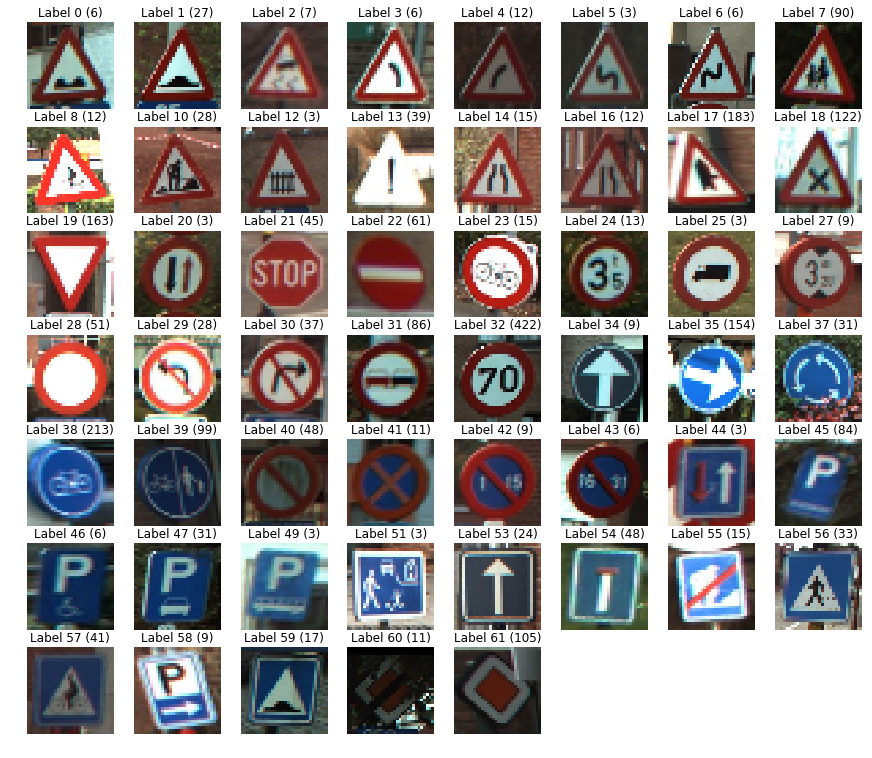

In [14]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32))
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

In [15]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.810
